# NASA Star Type Classification
dataset: https://www.kaggle.com/datasets/brsdincer/star-type-classification/data

### About Dataset
- Absolute Temperature (in K)
- Relative Luminosity (L/Lo)
- Relative Radius (R/Ro)
- Absolute Magnitude (Mv)
- Star Color
- Spectral Class (O, B, A, F, G, K, M)
- Star Type

Lo = 3.828 x 10^26 Watts (Avg Luminosity of Sun)
Ro = 6.9551 x 10^8 m (Avg Radius of Sun)

Star Type:
- Red Dwarf - 0
- Brown Dwarf - 1
- White Dwarf - 2
- Main Sequence - 3
- Super Giants - 4
- Hyper Giants - 5


In [334]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [335]:
data = pd.read_csv("dataset/Stars.csv")
data

,Temperature,L,R,A_M,Color,Spectral_Class,Type
0,3068,0.002400,0.1700,16.12,Red,M,0
1,3042,0.000500,0.1542,16.60,Red,M,0
2,2600,0.000300,0.1020,18.70,Red,M,0
3,2800,0.000200,0.1600,16.65,Red,M,0
4,1939,0.000138,0.1030,20.06,Red,M,0
...,...,...,...,...,...,...,...
235,38940,374830.000000,1356.0000,-9.93,Blue,O,5
236,30839,834042.000000,1194.0000,-10.63,Blue,O,5
237,8829,537493.000000,1423.0000,-10.73,White,A,5
238,9235,404940.000000,1112.0000,-11.23,White,A,5


## Data Analysis

In [336]:
data.rename(columns={
    "L": "Luminosity",
    "R": "Realative Radius",
    "A_M": "Absolute Magnitude",
    "Spectral_Class": "Spectral Class",
}, inplace=True)
data.columns

Index(['Temperature', 'Luminosity', 'Realative Radius', 'Absolute Magnitude',
       'Color', 'Spectral Class', 'Type'],
      dtype='object')

In [337]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Temperature         240 non-null    int64  
 1   Luminosity          240 non-null    float64
 2   Realative Radius    240 non-null    float64
 3   Absolute Magnitude  240 non-null    float64
 4   Color               240 non-null    object 
 5   Spectral Class      240 non-null    object 
 6   Type                240 non-null    int64  
dtypes: float64(3), int64(2), object(2)
memory usage: 13.3+ KB


In [338]:
#checking fot missing values
data.isnull().sum()

Temperature           0
Luminosity            0
Realative Radius      0
Absolute Magnitude    0
Color                 0
Spectral Class        0
Type                  0
dtype: int64

In [339]:
data.describe()

,Temperature,Luminosity,Realative Radius,Absolute Magnitude,Type
count,240.000000,240.000000,240.000000,240.000000,240.000000
mean,10497.462500,107188.361635,237.157781,4.382396,2.500000
std,9552.425037,179432.244940,517.155763,10.532512,1.711394
min,1939.000000,0.000080,0.008400,-11.920000,0.000000
25%,3344.250000,0.000865,0.102750,-6.232500,1.000000
50%,5776.000000,0.070500,0.762500,8.313000,2.500000
75%,15055.500000,198050.000000,42.750000,13.697500,4.000000
max,40000.000000,849420.000000,1948.500000,20.060000,5.000000


In [340]:
print("Rasporedjenost ciljne promjenjive - tip zvijezde:")
print(data["Type"].value_counts())

Rasporedjenost ciljne promjenjive - tip zvijezde:
Type
0    40
1    40
2    40
3    40
4    40
5    40
Name: count, dtype: int64


In [341]:
data["Color"] = data["Color"].astype("category")
data["Spectral Class"] = data["Spectral Class"].astype("category")
data["Type Name"] = pd.Categorical.from_codes(data["Type"], 
                                    categories=['Red Dwarf', 'Brown Dwarf', 'White Dwarf', 'Main Sequence' , 'Super Giant', 'Hyper Giant'])

#parametar Spectral Class ima neki poredak: O - najvruće, M - najhladnije zvijezde
data["Spectral Class"] = data["Spectral Class"].cat.reorder_categories(['M','K','G','F','A','B','O'], ordered=True)

#mapiramo spektralne klase
spectral_mapping = {'O': 6, 'B': 5, 'A': 4, 'F': 3, 'G': 2, 'K': 1, 'M': 0}
data["Spectral Class Num"] = data["Spectral Class"].map(spectral_mapping)
data["Spectral Class Num"] = data["Spectral Class Num"].astype(int)

In [342]:
data

,Temperature,Luminosity,Realative Radius,Absolute Magnitude,Color,Spectral Class,Type,Type Name,Spectral Class Num
0,3068,0.002400,0.1700,16.12,Red,M,0,Red Dwarf,0
1,3042,0.000500,0.1542,16.60,Red,M,0,Red Dwarf,0
2,2600,0.000300,0.1020,18.70,Red,M,0,Red Dwarf,0
3,2800,0.000200,0.1600,16.65,Red,M,0,Red Dwarf,0
4,1939,0.000138,0.1030,20.06,Red,M,0,Red Dwarf,0
...,...,...,...,...,...,...,...,...,...
235,38940,374830.000000,1356.0000,-9.93,Blue,O,5,Hyper Giant,6
236,30839,834042.000000,1194.0000,-10.63,Blue,O,5,Hyper Giant,6
237,8829,537493.000000,1423.0000,-10.73,White,A,5,Hyper Giant,4
238,9235,404940.000000,1112.0000,-11.23,White,A,5,Hyper Giant,4


In [343]:
#jedinstvene vrijednosti za atribut Color
print(data["Color"].unique().tolist())

['Red', 'Blue White', 'White', 'Yellowish White', 'Blue white', 'Pale yellow orange', 'Blue', 'Blue-white', 'Whitish', 'yellow-white', 'Orange', 'White-Yellow', 'white', 'yellowish', 'Yellowish', 'Orange-Red', 'Blue-White']


In [344]:
#previše različitih jedinstvenih vrijednosti za boju, mapiramo ih da bi pojednostavili
color_map = {
    r'Blue[\s-]?White|Blue white': 'blue-white',
    r'yellowish|Yellowish|Yellowish White|yellow-white white|white-Yellow': 'yellow-white',
    r'White|Whitish': 'white',
    r'Orange-Red|Pale yellow orange|Orange': 'orange',
    r'Red': 'red',
    r'Blue': 'blue'
}

def map_color(value):
    for pattern, new_value in color_map.items():
        if re.search(pattern, value):
            return new_value
    return value 

data["Color"] = data["Color"].apply(map_color)
print(data["Color"].unique().tolist())

['red', 'blue-white', 'white', 'yellow-white', 'orange', 'blue']


In [345]:
stars_per_class = data.groupby("Type")["Spectral Class"].value_counts().unstack()
stars_per_class

Spectral Class,M,K,G,F,A,B,O
Type,,,,,,,
0,40,0,0,0,0,0,0
1,40,0,0,0,0,0,0
2,0,0,0,9,7,24,0
3,0,4,0,8,10,13,5
4,9,0,0,0,0,2,29
5,22,2,1,0,2,7,6


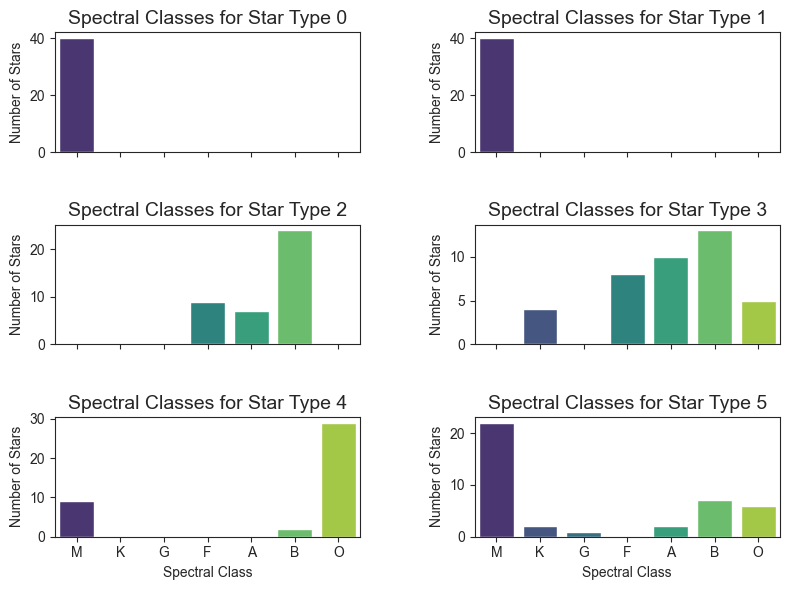

In [346]:
n_types = stars_per_class.shape[0]
fig, axes = plt.subplots(3, 2, figsize=(8, 6), sharex=True)

axes = axes.flatten()

for idx, (type_name, row) in enumerate(stars_per_class.iterrows()):
    sns.barplot(x=row.index, y=row.values, ax=axes[idx], hue=row.index, palette="viridis")
    axes[idx].set_title(f"Spectral Classes for Star Type {type_name}", fontsize=14)
    axes[idx].set_ylabel("Number of Stars")
    axes[idx].set_xlabel("Spectral Class")

plt.tight_layout(h_pad=3.0, w_pad=5.0)
plt.show()

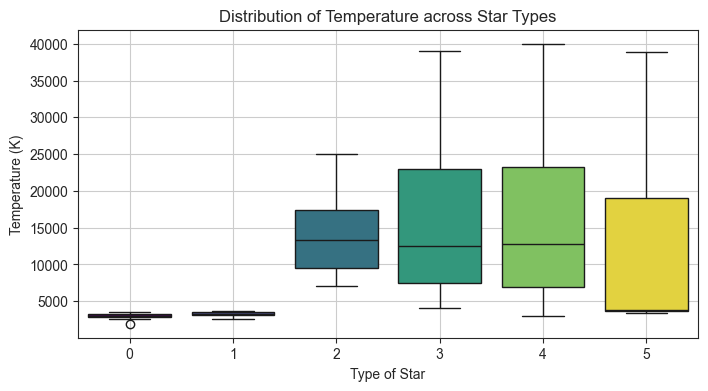

In [347]:
plt.figure(figsize=(8, 4))
sns.boxplot(data=data, x="Type", y="Temperature", hue="Type", legend=False, palette="viridis")
plt.title("Distribution of Temperature across Star Types")
plt.xlabel("Type of Star")
plt.ylabel("Temperature (K)")
plt.grid(True)
plt.show()

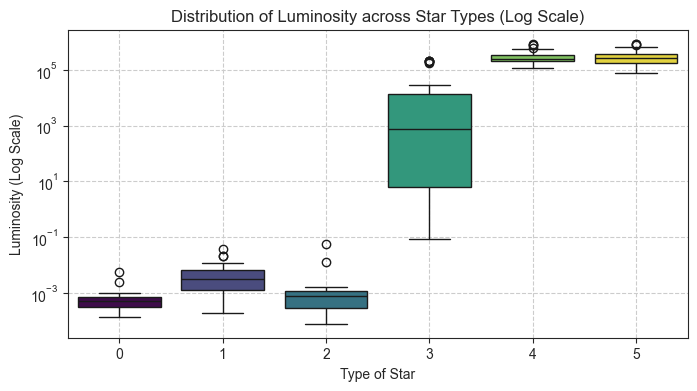

In [348]:
plt.figure(figsize=(8, 4))
sns.boxplot(data=data, x="Type", y="Luminosity", hue="Type", palette="viridis", legend=False)
plt.yscale('log')
plt.title("Distribution of Luminosity across Star Types (Log Scale)")
plt.xlabel("Type of Star")
plt.ylabel("Luminosity (Log Scale)")
plt.grid(True, which="both", ls="--")
plt.show()

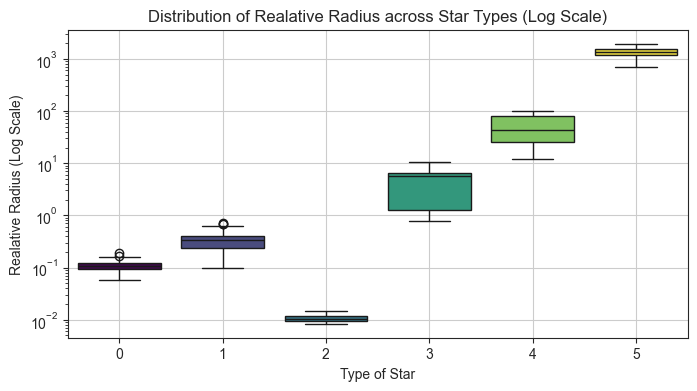

In [349]:
plt.figure(figsize=(8, 4))
sns.boxplot(data=data, x="Type", y="Realative Radius", hue="Type", legend=False, palette="viridis")
plt.yscale('log')
plt.title("Distribution of Realative Radius across Star Types (Log Scale)")
plt.xlabel("Type of Star")
plt.ylabel("Realative Radius (Log Scale)")
plt.grid(True)
plt.show()

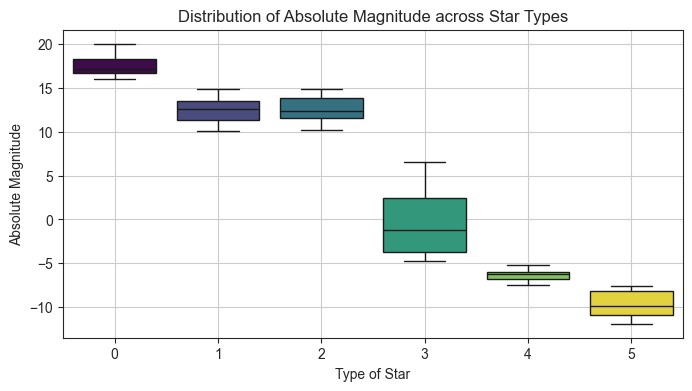

In [350]:
plt.figure(figsize=(8, 4))
sns.boxplot(data=data, x="Type", y="Absolute Magnitude", hue="Type", legend=False, palette="viridis")
plt.title("Distribution of Absolute Magnitude across Star Types")
plt.xlabel("Type of Star")
plt.ylabel("Absolute Magnitude")
plt.grid(True)
plt.show()

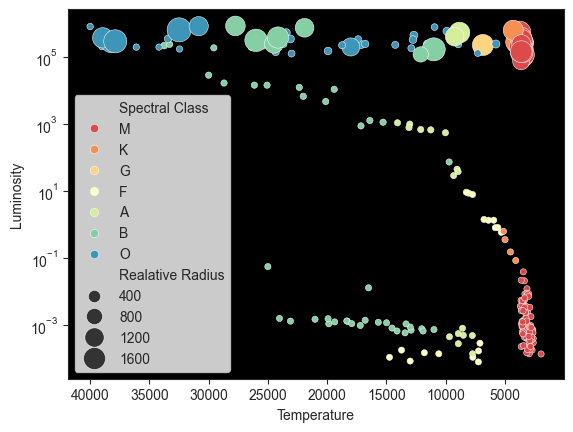

In [351]:
#Hertzprung-Rusell diagram
sns.set_style("ticks")
ax = sns.scatterplot(data, x="Temperature", y="Luminosity", hue="Spectral Class", size="Realative Radius", sizes=(20, 300), palette="Spectral")
ax.invert_xaxis()
ax.set_yscale("log")
ax.set_xlabel("Temperature")
ax.set_ylabel("Luminosity")
ax.set_facecolor('k')

<Axes: xlabel='Temperature', ylabel='Absolute Magnitude'>

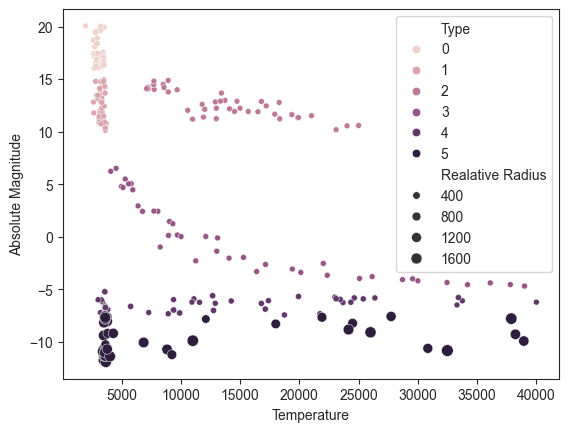

In [352]:
#rasporedjenost klastera u odnosu na Temperature, Absolute Magnitude i Realative Radius
sns.scatterplot(data, x="Temperature", y="Absolute Magnitude", hue='Type', size="Realative Radius")

<Axes: >

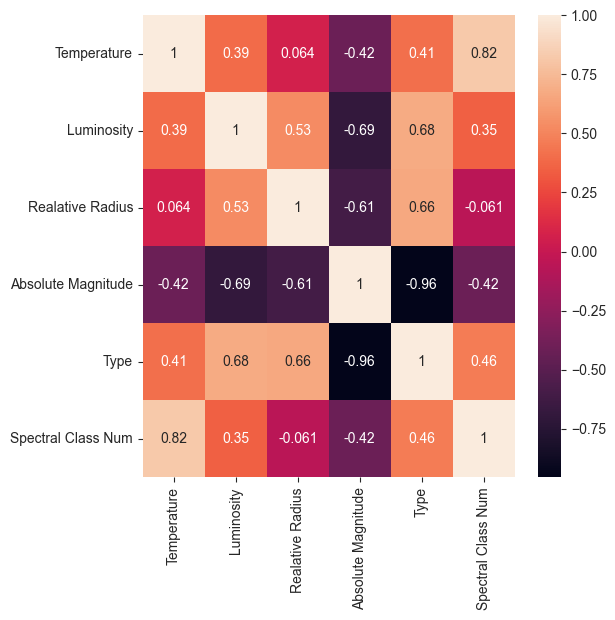

In [353]:
plt.figure(figsize=(6,6))
sns.heatmap(data.corr(numeric_only=True), annot=True)

- Absolute Magnitude i Type (-0.96) -> tip je jako negativno korelisan sa aps magnitudom, dakle što je zvijezda sjajnija to je viši numerički tip zvijezde
- Spectral Class i Temperature (0.82) -> spektralne klase su usko povezane sa temperaturom (ovo je smo znali od početka, O je najvruća a M najhladnija)
- Absolute Magnitude i Luminosity (-0.69) -> ovo je normalno; aps magnituda je mjera luminoznosti na inverznoj logaritamskoj astronomskoj skali
- Luminosity i Type (0.68) -> veća luminoznost znači viši numerički tip zvijezde (visoka zavisnost od luminoznosti)
- Relative Radius i Type (0.66) -> visoka zavisnost tipa od veličine zvijezde
- Temperature & Type (0.41) -> srednja pozitivna korelacija; toplije zvijezde imaju tendenciju da pripadaju višem numeričkom tipu zvijezde 

In [354]:
data.groupby("Type").corr(numeric_only=True)

Temperature  Luminosity  Realative Radius  \
Type                                                                 
0    Temperature            1.000000    0.261838          0.080064   
     Luminosity             0.261838    1.000000         -0.159083   
     Realative Radius       0.080064   -0.159083          1.000000   
     Absolute Magnitude    -0.198101   -0.177093         -0.120365   
     Spectral Class Num          NaN         NaN               NaN   
1    Temperature            1.000000    0.138601          0.517037   
     Luminosity             0.138601    1.000000         -0.049880   
     Realative Radius       0.517037   -0.049880          1.000000   
     Absolute Magnitude    -0.191694   -0.321309          0.068329   
     Spectral Class Num          NaN         NaN               NaN   
2    Temperature            1.000000    0.413196          0.180035   
     Luminosity             0.413196    1.000000         -0.130622   
     Realative Radius       0.180035   -0.130622          1.000000   
     Absolute Magnitude    -0.820193   -0.301477         -0.060761   
     Spectral Class Num     0.630365    0.188800          0.085794   
3    Temperature            1.000000    0.802601          0.820268   
     Luminosity             0.802601    1.000000          0.541232   
     Realative Radius       0.820268    0.541232          1.000000   
     Absolute Magnitude    -0.865062   -0.524928         -0.879941   
     Spectral Class Num     0.831546    0.568777          0.811348   
4    Temperature            1.000000    0.252056         -0.066814   
     Luminosity             0.252056    1.000000          0.096616   
     Realative Radius      -0.066814    0.096616          1.000000   
     Absolute Magnitude     0.276887   -0.072840          0.013425   
     Spectral Class Num     0.611555    0.259956          0.114948   
5    Temperature            1.000000    0.475826          0.128718   
     Luminosity             0.475826    1.000000          0.112732   
     Realative Radius       0.128718    0.112732          1.000000   
     Absolute Magnitude     0.251264    0.185925         -0.136955   
     Spectral Class Num     0.898726    0.471184          0.017694   

                         Absolute Magnitude  Spectral Class Num  
Type                                                             
0    Temperature                  -0.198101                 NaN  
     Luminosity                   -0.177093                 NaN  
     Realative Radius             -0.120365                 NaN  
     Absolute Magnitude            1.000000                 NaN  
     Spectral Class Num                 NaN                 NaN  
1    Temperature                  -0.191694                 NaN  
     Luminosity                   -0.321309                 NaN  
     Realative Radius              0.068329                 NaN  
     Absolute Magnitude            1.000000                 NaN  
     Spectral Class Num                 NaN                 NaN  
2    Temperature                  -0.820193            0.630365  
     Luminosity                   -0.301477            0.188800  
     Realative Radius             -0.060761            0.085794  
     Absolute Magnitude            1.000000           -0.592222  
     Spectral Class Num           -0.592222            1.000000  
3    Temperature                  -0.865062            0.831546  
     Luminosity                   -0.524928            0.568777  
     Realative Radius             -0.879941            0.811348  
     Absolute Magnitude            1.000000           -0.900400  
     Spectral Class Num           -0.900400            1.000000  
4    Temperature                   0.276887            0.611555  
     Luminosity                   -0.072840            0.259956  
     Realative Radius              0.013425            0.114948  
     Absolute Magnitude            1.000000            0.041141  
     Spectral Class Num            0.041141            1.000000  
5 

## Modelling

Classifiers:
- DecisionTreeClassifier
- KNeighborsClassifier
- LogisticRegression
- GaussianNB

In [355]:
features = ["Temperature", "Luminosity", "Realative Radius", "Absolute Magnitude", "Spectral Class Num"]

X = data[features]
y = data["Type"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [356]:
#DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        11
           2       1.00      1.00      1.00         9
           3       1.00      1.00      1.00         9
           4       1.00      1.00      1.00         9
           5       1.00      1.00      1.00        12

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60


Confusion Matrix:
 [[10  0  0  0  0  0]
 [ 0 11  0  0  0  0]
 [ 0  0  9  0  0  0]
 [ 0  0  0  9  0  0]
 [ 0  0  0  0  9  0]
 [ 0  0  0  0  0 12]]


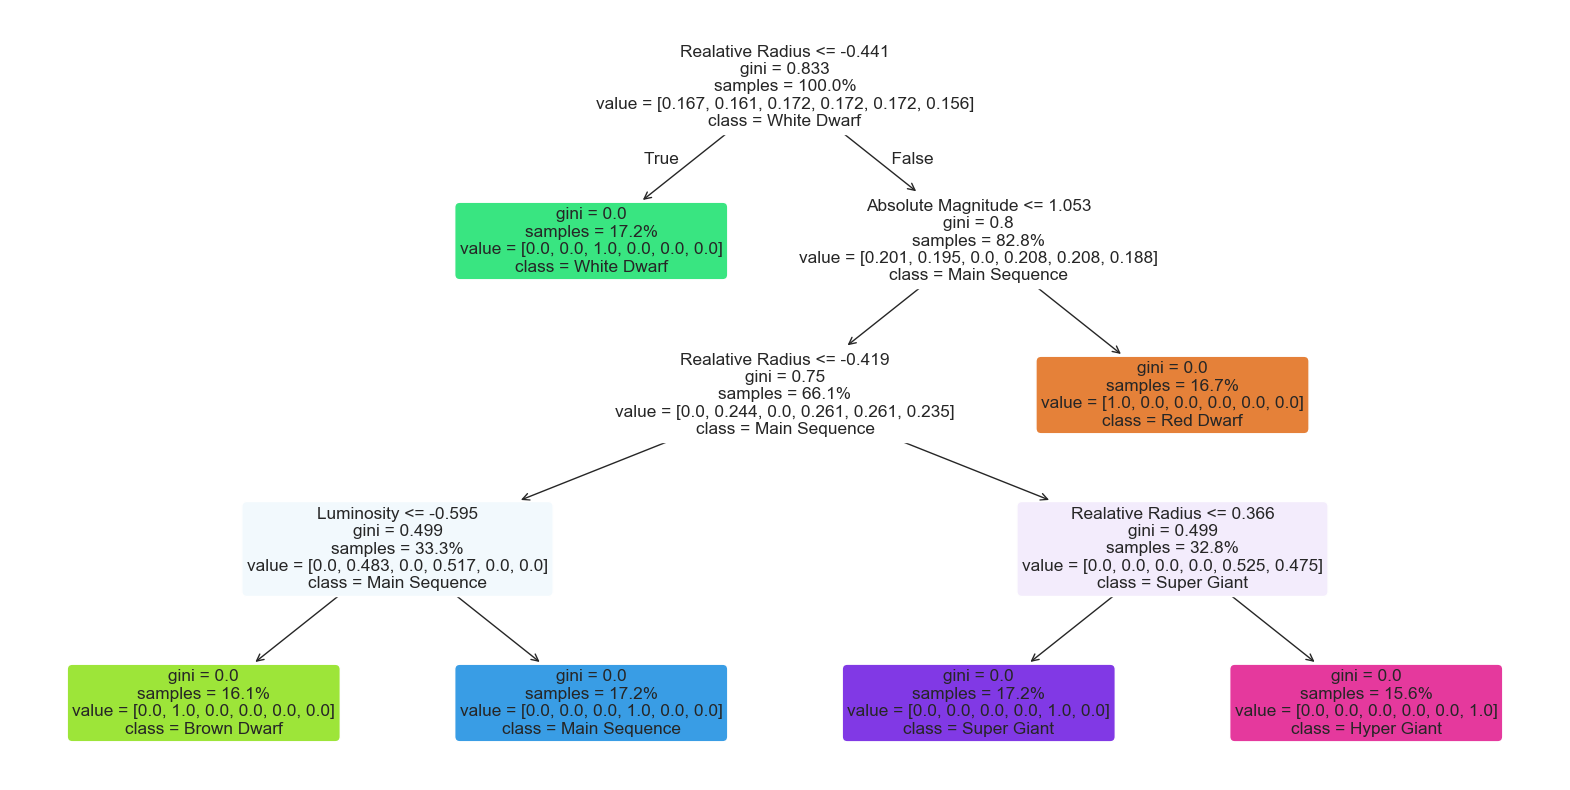

In [357]:
class_names = ['Red Dwarf', 'Brown Dwarf', 'White Dwarf', 'Main Sequence' , 'Super Giant', 'Hyper Giant']

plt.figure(figsize=(20,10))
plot_tree(clf, 
          filled=True, 
          feature_names=features, 
          class_names=class_names,
          rounded=True,
          proportion=True)
plt.show()

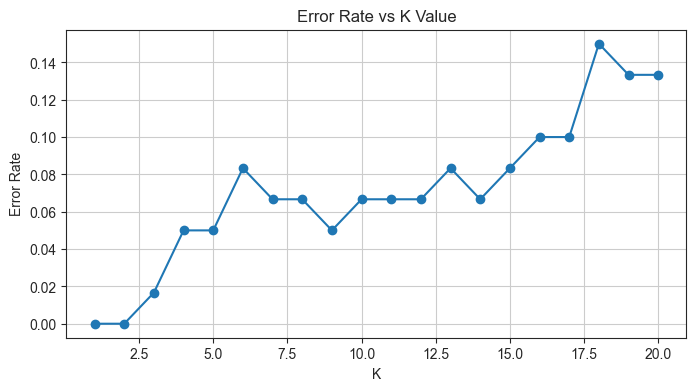

Optimal number of neighbor (k): 1
Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        11
           2       1.00      1.00      1.00         9
           3       1.00      1.00      1.00         9
           4       1.00      1.00      1.00         9
           5       1.00      1.00      1.00        12

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60


Confusion Matrix:
 [[10  0  0  0  0  0]
 [ 0 11  0  0  0  0]
 [ 0  0  9  0  0  0]
 [ 0  0  0  9  0  0]
 [ 0  0  0  0  9  0]
 [ 0  0  0  0  0 12]]


In [358]:
#KNeighborsClassifier

errors = []
for k in range(1, 21):
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)
    y_pred_k = model.predict(X_test)
    errors.append(1 - accuracy_score(y_test, y_pred_k)) 

plt.figure(figsize=(8, 4))
plt.plot(range(1, 21), errors, marker='o')
plt.title("Error Rate vs K Value")
plt.xlabel("K")
plt.ylabel("Error Rate")
plt.grid(True)
plt.show()

optimal_k = range(1, 21)[errors.index(min(errors))]
print(f"Optimal number of neighbor (k): {optimal_k}")

knn = KNeighborsClassifier(n_neighbors=optimal_k)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

In [359]:
#Logistic Regression

logreg = LogisticRegression(solver='lbfgs', max_iter=2000)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.9333333333333333

Classification Report:
               precision    recall  f1-score   support

           0       0.91      1.00      0.95        10
           1       0.83      0.91      0.87        11
           2       1.00      1.00      1.00         9
           3       1.00      0.67      0.80         9
           4       0.90      1.00      0.95         9
           5       1.00      1.00      1.00        12

    accuracy                           0.93        60
   macro avg       0.94      0.93      0.93        60
weighted avg       0.94      0.93      0.93        60


Confusion Matrix:
 [[10  0  0  0  0  0]
 [ 1 10  0  0  0  0]
 [ 0  0  9  0  0  0]
 [ 0  2  0  6  1  0]
 [ 0  0  0  0  9  0]
 [ 0  0  0  0  0 12]]


In [360]:
#GaussianNB

nbc = GaussianNB()
nbc.fit(X_train, y_train)
y_pred = nbc.predict(X_test)  

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.9666666666666667

Classification Report:
               precision    recall  f1-score   support

           0       0.91      1.00      0.95        10
           1       1.00      0.91      0.95        11
           2       1.00      1.00      1.00         9
           3       1.00      0.89      0.94         9
           4       0.90      1.00      0.95         9
           5       1.00      1.00      1.00        12

    accuracy                           0.97        60
   macro avg       0.97      0.97      0.97        60
weighted avg       0.97      0.97      0.97        60


Confusion Matrix:
 [[10  0  0  0  0  0]
 [ 1 10  0  0  0  0]
 [ 0  0  9  0  0  0]
 [ 0  0  0  8  1  0]
 [ 0  0  0  0  9  0]
 [ 0  0  0  0  0 12]]
